In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import pandas as pd

In [2]:
assert torch.cuda.is_available and torch.has_cudnn

In [3]:
torch.cuda.get_device_name(0)

'Tesla P40'

In [424]:
snli_train_path = './snli_train.tsv'
snli_val_path = './snli_val.tsv'
mnli_train_path = './mnli_train.tsv'
mnli_val_path = './mnli_val.tsv'

In [5]:
label_map = {
    'contradiction':0, 
    'entailment':1, 
    'neutral':2
}
fix_length = 30

In [293]:
TEXT = torchtext.data.ReversibleField(sequential=True, lower=True, include_lengths=True,
                                      batch_first=True)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, preprocessing=lambda x: label_map[x])

In [294]:
snli_train_data = torchtext.data.TabularDataset(snli_train_path,format='tsv', 
                                                    skip_header = True,
                                                    fields=[('sentence1',TEXT),('sentence2',TEXT),('label',LABEL)])
snli_val_data = torchtext.data.TabularDataset(snli_val_path,format='tsv', 
                                                  skip_header = True,
                                                  fields=[('sentence1',TEXT),('sentence2',TEXT),('label',LABEL)])

In [295]:
TEXT.build_vocab(snli_train_data, snli_val_data, 
                 vectors=torchtext.vocab.Vectors(name='wiki-news-300d-1M.vec'))

In [296]:
snli_train_iter = torchtext.data.BucketIterator(snli_train_data,
                                                batch_size=32,
                                                shuffle=True,
#                                                 sort_key=lambda x: len(x.sentence1)+len(x.sentence2),
                                                sort_key=lambda x: data.interleave_keys(len(x.sentence1), len(x.sentence2)),
                                                device=torch.device('cuda'))
snli_val_iter = torchtext.data.BucketIterator(snli_val_data,
                                                batch_size=32,
                                                shuffle=False,
#                                                 sort_key=lambda x: len(x.sentence1)+len(x.sentence2),
                                                sort_key=lambda x: data.interleave_keys(len(x.sentence1), len(x.sentence2)),
                                                device=torch.device('cuda'))
snli_train_iter_for_val = torchtext.data.BucketIterator(snli_train_data,
                                                batch_size=32,
                                                shuffle=True,
#                                                 sort_key=lambda x: len(x.sentence1)+len(x.sentence2),
                                                sort_key=lambda x: data.interleave_keys(len(x.sentence1), len(x.sentence2)),
                                                device=torch.device('cuda'))

In [61]:
def test_model(test_iter, model):
    correct = 0
    total = 0
    model.eval()
    test_loss = 0.0
    for batch in test_iter:
        pred = model(batch.sentence1, batch.sentence2)
        outputs = F.softmax(pred, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        loss = F.cross_entropy(pred, batch.label)
        test_loss += loss.item()

        total += batch.label.size(0)
        correct += predicted.eq(batch.label.view_as(predicted)).sum().item()
    return (100 * correct / total), test_loss/len(test_iter)

In [108]:
class RNN(nn.Module):
    def __init__(self, in_size, hidden_size, num_classes, vocab, num_layers, dropout=0):
        super(RNN, self).__init__()

        self.in_size, self.hidden_size = in_size, hidden_size
        self.num_classes, self.num_layers = num_classes, num_layers
        self.vocab = vocab
        
        self.embedding = nn.Embedding(self.vocab.vectors.shape[0],vocab.vectors.shape[1])
        self.embedding.weight = nn.Parameter(self.vocab.vectors, requires_grad=False)
        
        self.gru1 = nn.GRU(input_size=self.in_size, hidden_size=hidden_size, num_layers=num_layers,
                          batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(input_size=self.in_size, hidden_size=hidden_size, num_layers=num_layers,
                          batch_first=True, bidirectional=True)
        
        self.linear_1 = nn.Linear(int(hidden_size*2), int(hidden_size))
        self.linear_2 = nn.Linear(int(hidden_size), self.num_classes)
        
        self.dropout = nn.Dropout(dropout)
        
        hidden1 = torch.zeros(self.num_layers, self.hidden_size)
        nn.init.normal_(hidden1, mean=0, std=0.001)
        self.hidden1 = torch.nn.Parameter(hidden1,requires_grad=True)
        
        hidden2 = torch.zeros(self.num_layers, self.hidden_size)
        nn.init.normal_(hidden2, mean=0, std=0.001)
        self.hidden2 = torch.nn.Parameter(hidden2,requires_grad=True)

    def init_hidden1(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        hidden1 = torch.cat([self.hidden1]*batch_size,dim=0)
        hidden1 = torch.stack([hidden1]*2, dim=0)
        return hidden1
    
    def init_hidden2(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        hidden2 = torch.cat([self.hidden2]*batch_size,dim=0)
        hidden2 = torch.stack([hidden2]*2, dim=0)
        return hidden2



    def forward(self, x1, x2):
        # reset hidden state
        
        len1 = x1[1]
        len2 = x2[1]
        
        data1 = self.embedding(x1[0])
        data2 = self.embedding(x2[0])
        
        batch_size = data1.shape[0]
        
        hidden1 = self.init_hidden1(batch_size)
        hidden2 = self.init_hidden2(batch_size)
        
#         print(hidden1.shape)
#         print(hidden1)

        # sort hidden layer and length for pack_padded_sequence
        sorted_idx1 = np.argsort(-len1)
        sorted_idx2 = np.argsort(-len2)
        
        len1 = len1[sorted_idx1]
        len2 = len2[sorted_idx2]
        data1 = data1[sorted_idx1]
        data2 = data2[sorted_idx2]

        # pack padded sequence
        data1 = nn.utils.rnn.pack_padded_sequence(data1, len1, batch_first=True)
        data2 = nn.utils.rnn.pack_padded_sequence(data2, len2, batch_first=True)
        
#         print(hidden1.shape)
        
        # fprop though RNN
        data1_out, hidden1 = self.gru1(data1, hidden1)
        data2_out, hidden2 = self.gru2(data2, hidden2)
        
        # sum the hidden state on the first dimension
        hidden1 = torch.sum(hidden1, dim=0)
        hidden2 = torch.sum(hidden2, dim=0)
        
        # resort by original order
        hidden1 = hidden1[np.argsort(sorted_idx1)]
        hidden2 = hidden2[np.argsort(sorted_idx2)]
        
        conc_layer = torch.cat([hidden1, hidden2], dim=1)
        
#         print(conc_layer.shape)
        
        pred = self.linear_1(conc_layer)
        pred = torch.tanh(pred)
        pred = self.dropout(pred)
        pred = self.linear_2(pred)
        pred = torch.tanh(pred)
        return pred
        
        # fprop though RNN
#         data1_out, hidden1 = self.gru1(data1, hidden1)
        
        
#         # undo packing
#         rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
#         # sum hidden activations of RNN across time
#         rnn_out = torch.sum(rnn_out, dim=1)

#         logits = self.linear(rnn_out)
#         return logits


In [65]:
model = RNN(in_size=300, hidden_size=300, num_classes=3, vocab=TEXT.vocab, num_layers=1)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (batch) in enumerate(snli_train_iter):
        model.train()
        optimizer.zero_grad()
        pred = model(batch.sentence1, batch.sentence2)
        loss = F.cross_entropy(pred,batch.label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        val_period = 1000
        if i > 0 and i % val_period == 0:
            # validate
            model.eval()
            trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
#             trn_acc = None
            val_acc, val_loss = test_model(snli_val_iter, model)
    
            print('Epoch: [{}/{}], Step: [{}/{}], Trn Acc: {:.2f}, Val Acc: {:.2f}, Trn Loss: {:.2f}, Val Loss: {:.2f}'
                  .format(epoch+1, num_epochs, i+1, len(snli_train_iter), trn_acc, val_acc,
                          running_loss/val_period, val_loss))
            running_loss = 0.0
#         break
#     break

Epoch: [1/10], Step: [1001/3125], Trn Acc: 60.55, Val Acc: 59.60, Trn Loss: 0.95, Val Loss: 0.89
Epoch: [1/10], Step: [2001/3125], Trn Acc: 62.33, Val Acc: 60.20, Trn Loss: 0.88, Val Loss: 0.88
Epoch: [1/10], Step: [3001/3125], Trn Acc: 64.52, Val Acc: 61.80, Trn Loss: 0.86, Val Loss: 0.88
Epoch: [2/10], Step: [1001/3125], Trn Acc: 63.91, Val Acc: 61.30, Trn Loss: 0.83, Val Loss: 0.88
Epoch: [2/10], Step: [2001/3125], Trn Acc: 66.53, Val Acc: 65.20, Trn Loss: 0.82, Val Loss: 0.84
Epoch: [2/10], Step: [3001/3125], Trn Acc: 68.06, Val Acc: 64.70, Trn Loss: 0.81, Val Loss: 0.84
Epoch: [3/10], Step: [1001/3125], Trn Acc: 69.80, Val Acc: 66.00, Trn Loss: 0.78, Val Loss: 0.82
Epoch: [3/10], Step: [2001/3125], Trn Acc: 70.80, Val Acc: 64.90, Trn Loss: 0.76, Val Loss: 0.83
Epoch: [3/10], Step: [3001/3125], Trn Acc: 71.49, Val Acc: 64.40, Trn Loss: 0.76, Val Loss: 0.81
Epoch: [4/10], Step: [1001/3125], Trn Acc: 73.23, Val Acc: 67.30, Trn Loss: 0.72, Val Loss: 0.80
Epoch: [4/10], Step: [2001/312

In [317]:
class CNN(nn.Module):
    def __init__(self, in_size, hidden_size, num_classes, vocab, kernel_size=3, dropout=0):

        super(CNN, self).__init__()

        self.in_size, self.hidden_size = in_size, hidden_size
        self.num_classes = num_classes
        self.vocab = vocab
        
        self.embedding = nn.Embedding(self.vocab.vectors.shape[0],vocab.vectors.shape[1])
        self.embedding.weight = torch.nn.Parameter(self.vocab.vectors, requires_grad=False)
        
        self.conv1_1 = nn.Conv1d(in_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2_1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
        
        self.conv1_2 = nn.Conv1d(in_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2_2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
#         self.conv1_2 = self.conv1_1
#         self.conv2_2 = self.conv2_1
        
#         self.maxpool = nn.MaxPool1d(3, stride=3)

#         self.linear_1 = torch.nn.Linear(int(hidden_size/3*fix_length*2), int(hidden_size/3*fix_length))
#         self.linear_2 = torch.nn.Linear(int(hidden_size/3*fix_length), self.num_classes)

        self.linear_1 = torch.nn.Linear(int(hidden_size*2), int(hidden_size))
        self.linear_2 = torch.nn.Linear(int(hidden_size), self.num_classes)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1, x2):
        
        len1 = x1[1]
        len2 = x2[1]
        
        x1 = self.embedding(x1[0])
        x2 = self.embedding(x2[0])
        
        hidden1 = self.conv1_1(x1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(hidden1.shape[0], hidden1.shape[1], hidden1.size(-1))
        hidden1 = self.conv2_1(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(hidden1.shape[0], hidden1.shape[1], hidden1.size(-1))
        
        hidden2 = self.conv1_2(x2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(hidden2.shape[0], hidden2.shape[1], hidden2.size(-1))
        hidden2 = self.conv2_2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(hidden2.shape[0], hidden2.shape[1], hidden2.size(-1))

#         print(hidden1.shape)
#         print(hidden2.shape)

        
#         hidden1 = self.maxpool(hidden1)
#         hidden2 = self.maxpool(hidden2)
        
#         print(hidden1.shape)
#         print(hidden2.shape)
        
        
#         hidden1 = hidden1.view(hidden1.size(0), -1)
#         hidden2 = hidden1.view(hidden2.size(0), -1)
        
        hidden1,_ = torch.max(hidden1, dim=1)
        hidden2,_ = torch.max(hidden2, dim=1)
    
#         print(hidden1.shape)
#         print(hidden2.shape)
        
        conc_layer = torch.cat([hidden1, hidden2], dim=1)
        
#         print(conc_layer.shape)
        
        pred = self.linear_1(conc_layer)
        pred = torch.tanh(pred)
        pred = self.dropout(pred)
        pred = self.linear_2(pred)
        pred = torch.tanh(pred)
        return pred

In [68]:
model = CNN(in_size=300, hidden_size=300, num_classes=3, vocab=TEXT.vocab)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (batch) in enumerate(snli_train_iter):
        model.train()
        optimizer.zero_grad()
        pred = model(batch.sentence1, batch.sentence2)
        loss = F.cross_entropy(pred,batch.label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        val_period = 1000
        if i > 0 and i % val_period == 0:
            # validate
            model.eval()
            trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
#             trn_acc = None
            val_acc, val_loss = test_model(snli_val_iter, model)
    
            print('Epoch: [{}/{}], Step: [{}/{}], Trn Acc: {:.2f}, Val Acc: {:.2f}, Trn Loss: {:.2f}, Val Loss: {:.2f}'
                  .format(epoch+1, num_epochs, i+1, len(snli_train_iter), trn_acc, val_acc,
                          running_loss/val_period, val_loss))
            running_loss = 0.0
#         break
#     break

Epoch: [1/3], Step: [1001/3125], Trn Acc: 58.51, Val Acc: 56.90, Trn Loss: 0.92, Val Loss: 0.95
Epoch: [1/3], Step: [2001/3125], Trn Acc: 64.64, Val Acc: 61.90, Trn Loss: 0.87, Val Loss: 0.86
Epoch: [1/3], Step: [3001/3125], Trn Acc: 65.06, Val Acc: 60.40, Trn Loss: 0.84, Val Loss: 0.87
Epoch: [2/3], Step: [1001/3125], Trn Acc: 66.73, Val Acc: 63.70, Trn Loss: 0.81, Val Loss: 0.84
Epoch: [2/3], Step: [2001/3125], Trn Acc: 68.31, Val Acc: 62.10, Trn Loss: 0.80, Val Loss: 0.83
Epoch: [2/3], Step: [3001/3125], Trn Acc: 69.44, Val Acc: 63.40, Trn Loss: 0.81, Val Loss: 0.83
Epoch: [3/3], Step: [1001/3125], Trn Acc: 70.80, Val Acc: 63.10, Trn Loss: 0.76, Val Loss: 0.85
Epoch: [3/3], Step: [2001/3125], Trn Acc: 71.66, Val Acc: 62.00, Trn Loss: 0.76, Val Loss: 0.85
Epoch: [3/3], Step: [3001/3125], Trn Acc: 71.21, Val Acc: 63.30, Trn Loss: 0.76, Val Loss: 0.86


# Tuning over hyperparameters

In [90]:
output_path = './output_img/'

## Hidden dimension of RNN

In [251]:
hidden_sizes = [100, 300, 500]

In [252]:
trn_acc_total = []
val_acc_total = []
trn_loss_total = []
val_loss_total = []

In [253]:
for hidden_size in hidden_sizes:
    trn_acc_values = []
    val_acc_values = []
    trn_loss_values = []
    val_loss_values = []
    
    model = RNN(in_size=300, hidden_size=hidden_size, num_classes=3, vocab=TEXT.vocab, num_layers=1)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 8
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (batch) in enumerate(snli_train_iter):
            model.train()
            optimizer.zero_grad()
            pred = model(batch.sentence1, batch.sentence2)
            loss = F.cross_entropy(pred,batch.label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            val_period = 500
            if i > 0 and i % val_period == 0:
                # validate
                model.eval()
                trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
                val_acc, val_loss = test_model(snli_val_iter, model)

                print('Epoch: [{}/{}], Step: [{}/{}], Trn Acc: {:.2f}, Val Acc: {:.2f}, Trn Loss: {:.2f}, Val Loss: {:.2f}'
                      .format(epoch+1, num_epochs, i+1, len(snli_train_iter), trn_acc, val_acc,
                              running_loss/val_period, val_loss))
                
                trn_acc_values.append(trn_acc)
                val_acc_values.append(val_acc)
                trn_loss_values.append(running_loss/val_period)
                val_loss_values.append(val_loss)
                
                running_loss = 0.0
                
    trn_acc_total.append(trn_acc_values)
    val_acc_total.append(val_acc_values)
    trn_loss_total.append(trn_loss_values)
    val_loss_total.append(val_loss_values)

Epoch: [1/8], Step: [501/3125], Trn Acc: 57.33, Val Acc: 56.10, Trn Loss: 0.97, Val Loss: 0.94
Epoch: [1/8], Step: [1001/3125], Trn Acc: 60.83, Val Acc: 60.30, Trn Loss: 0.91, Val Loss: 0.89
Epoch: [1/8], Step: [1501/3125], Trn Acc: 61.66, Val Acc: 59.40, Trn Loss: 0.89, Val Loss: 0.88
Epoch: [1/8], Step: [2001/3125], Trn Acc: 62.19, Val Acc: 58.30, Trn Loss: 0.87, Val Loss: 0.90
Epoch: [1/8], Step: [2501/3125], Trn Acc: 62.86, Val Acc: 62.30, Trn Loss: 0.87, Val Loss: 0.86
Epoch: [1/8], Step: [3001/3125], Trn Acc: 64.22, Val Acc: 61.80, Trn Loss: 0.85, Val Loss: 0.87
Epoch: [2/8], Step: [501/3125], Trn Acc: 64.75, Val Acc: 63.00, Trn Loss: 0.83, Val Loss: 0.87
Epoch: [2/8], Step: [1001/3125], Trn Acc: 64.94, Val Acc: 63.30, Trn Loss: 0.83, Val Loss: 0.85
Epoch: [2/8], Step: [1501/3125], Trn Acc: 65.42, Val Acc: 63.60, Trn Loss: 0.83, Val Loss: 0.85
Epoch: [2/8], Step: [2001/3125], Trn Acc: 65.25, Val Acc: 62.80, Trn Loss: 0.83, Val Loss: 0.85
Epoch: [2/8], Step: [2501/3125], Trn Acc: 

Epoch: [7/8], Step: [1501/3125], Trn Acc: 82.41, Val Acc: 66.60, Trn Loss: 0.58, Val Loss: 0.82
Epoch: [7/8], Step: [2001/3125], Trn Acc: 82.71, Val Acc: 66.10, Trn Loss: 0.59, Val Loss: 0.82
Epoch: [7/8], Step: [2501/3125], Trn Acc: 83.38, Val Acc: 65.70, Trn Loss: 0.59, Val Loss: 0.80
Epoch: [7/8], Step: [3001/3125], Trn Acc: 84.11, Val Acc: 68.00, Trn Loss: 0.60, Val Loss: 0.79
Epoch: [8/8], Step: [501/3125], Trn Acc: 85.51, Val Acc: 65.60, Trn Loss: 0.51, Val Loss: 0.83
Epoch: [8/8], Step: [1001/3125], Trn Acc: 85.46, Val Acc: 65.60, Trn Loss: 0.54, Val Loss: 0.82
Epoch: [8/8], Step: [1501/3125], Trn Acc: 85.19, Val Acc: 66.60, Trn Loss: 0.54, Val Loss: 0.82
Epoch: [8/8], Step: [2001/3125], Trn Acc: 85.65, Val Acc: 65.60, Trn Loss: 0.54, Val Loss: 0.83
Epoch: [8/8], Step: [2501/3125], Trn Acc: 86.01, Val Acc: 65.00, Trn Loss: 0.55, Val Loss: 0.84
Epoch: [8/8], Step: [3001/3125], Trn Acc: 87.17, Val Acc: 66.40, Trn Loss: 0.55, Val Loss: 0.82
Epoch: [1/8], Step: [501/3125], Trn Acc: 

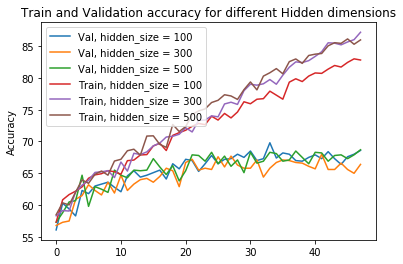

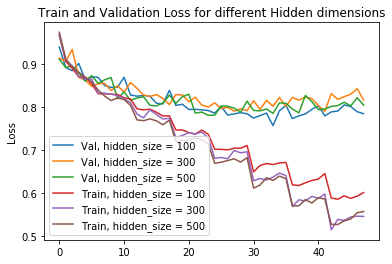

In [257]:
plt.clf()
for i, val_acc in enumerate(val_acc_total):
    plt.plot(val_acc, label='Val, hidden_size = %d' % hidden_sizes[i])
    
for i, trn_acc in enumerate(trn_acc_total):
    plt.plot(trn_acc, label='Train, hidden_size = %d' % hidden_sizes[i])
    
plt.title('Train and Validation accuracy for different Hidden dimensions')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(output_path+'rnn_hidden_size_acc.png')
plt.show()

plt.clf()
for i, val_loss in enumerate(val_loss_total):
    plt.plot(val_loss, label='Val, hidden_size = %d' % hidden_sizes[i])
    
for i, trn_loss in enumerate(trn_loss_total):
    plt.plot(trn_loss, label='Train, hidden_size = %d' % hidden_sizes[i])
    
plt.title('Train and Validation Loss for different Hidden dimensions')
plt.ylabel('Loss')
plt.legend()
plt.savefig(output_path+'rnn_hidden_size_loss.png')
plt.show()

In [254]:
# accandlosspath = './output_accandloss/rnn_hidden_size_'
# np.save(accandlosspath+'trn_acc_total', np.asarray(trn_acc_total))
# np.save(accandlosspath+'val_acc_total', np.asarray(val_acc_total))
# np.save(accandlosspath+'trn_loss_total', np.asarray(trn_loss_total))
# np.save(accandlosspath+'val_loss_total', np.asarray(val_loss_total))

In [255]:
accandlosspath = './output_accandloss/rnn_hidden_size_'
trn_acc_total1 = np.load(accandlosspath+'trn_acc_total.npy')
val_acc_total1 = np.load(accandlosspath+'val_acc_total.npy')
trn_loss_total1 = np.load(accandlosspath+'trn_loss_total.npy')
val_loss_total1 = np.load(accandlosspath+'val_loss_total.npy')

In [231]:
# val_loss_total=np.delete(val_loss_total, [1,2,3], 0)

## Dropout of RNN

In [159]:
dropouts = [0.05, 0.15, 0.3]

In [160]:
trn_acc_total = []
val_acc_total = []
trn_loss_total = []
val_loss_total = []

In [ ]:
for dropout in dropouts:
    trn_acc_values = []
    val_acc_values = []
    trn_loss_values = []
    val_loss_values = []
    
    model = RNN(in_size=300, hidden_size=100, num_classes=3, vocab=TEXT.vocab, num_layers=1, dropout=dropout)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 8
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (batch) in enumerate(snli_train_iter):
            model.train()
            optimizer.zero_grad()
            pred = model(batch.sentence1, batch.sentence2)
            loss = F.cross_entropy(pred,batch.label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            val_period = 500
            if i > 0 and i % val_period == 0:
                # validate
                model.eval()
                trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
                val_acc, val_loss = test_model(snli_val_iter, model)

                print('Epoch: [{}/{}], Step: [{}/{}], Trn Acc: {:.2f}, Val Acc: {:.2f}, Trn Loss: {:.2f}, Val Loss: {:.2f}'
                      .format(epoch+1, num_epochs, i+1, len(snli_train_iter), trn_acc, val_acc,
                              running_loss/val_period, val_loss))
                
                trn_acc_values.append(trn_acc)
                val_acc_values.append(val_acc)
                trn_loss_values.append(running_loss/val_period)
                val_loss_values.append(val_loss)
                
                running_loss = 0.0
                
    trn_acc_total.append(trn_acc_values)
    val_acc_total.append(val_acc_values)
    trn_loss_total.append(trn_loss_values)
    val_loss_total.append(val_loss_values)

In [ ]:
# trn_acc_total.insert(0, np.load('./output_accandloss/rnn_hidden_size_'+'trn_acc_total.npy')[0])
# val_acc_total.insert(0, np.load('./output_accandloss/rnn_hidden_size_'+'val_acc_total.npy')[0])
# val_loss_total.insert(0, np.load('./output_accandloss/rnn_hidden_size_'+'val_loss_total.npy')[0])
# trn_loss_total.insert(0, np.load('./output_accandloss/rnn_hidden_size_'+'trn_loss_total.npy')[0])

In [276]:
dropouts.append(0.0)

In [277]:
dropouts

[0.05, 0.15, 0.3, 0.0]

In [278]:
# accandlosspath = './output_accandloss/rnn_dropout_'
# trn_acc_total = np.load(accandlosspath+'trn_acc_total.npy')
# val_acc_total = np.load(accandlosspath+'val_acc_total.npy')
# trn_loss_total = np.load(accandlosspath+'trn_loss_total.npy')
# val_loss_total = np.load(accandlosspath+'val_loss_total.npy')

In [279]:
# trn_acc_total = np.append(trn_acc_total, [np.load('./output_accandloss/rnn_hidden_size_'+'trn_acc_total.npy')[0]], 0)
# val_acc_total = np.append(val_acc_total, [np.load('./output_accandloss/rnn_hidden_size_'+'val_acc_total.npy')[0]], 0)
# trn_loss_total = np.append(trn_loss_total, [np.load('./output_accandloss/rnn_hidden_size_'+'trn_loss_total.npy')[0]], 0)
# val_loss_total = np.append(val_loss_total, [np.load('./output_accandloss/rnn_hidden_size_'+'val_loss_total.npy')[0]], 0)

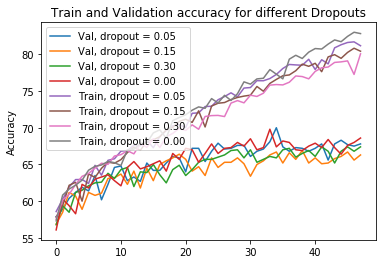

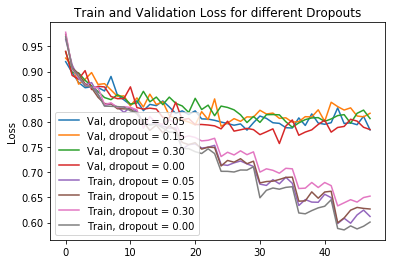

In [281]:
plt.clf()
for i, val_acc in enumerate(val_acc_total):
    plt.plot(val_acc, label='Val, dropout = %.2f' % dropouts[i])
    
for i, trn_acc in enumerate(trn_acc_total):
    plt.plot(trn_acc, label='Train, dropout = %.2f' % dropouts[i])
    
plt.title('Train and Validation accuracy for different Dropouts')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(output_path+'rnn_dropout_acc.png')
plt.show()

plt.clf()
for i, val_loss in enumerate(val_loss_total):
    plt.plot(val_loss, label='Val, dropout = %.2f' % dropouts[i])
    
for i, trn_loss in enumerate(trn_loss_total):
    plt.plot(trn_loss, label='Train, dropout = %.2f' % dropouts[i])
    
plt.title('Train and Validation Loss for different Dropouts')
plt.ylabel('Loss')
plt.legend()
plt.savefig(output_path+'rnn_dropout_loss.png')
plt.show()

In [ ]:
# accandlosspath = './output_accandloss/rnn_dropout_'
# np.save(accandlosspath+'trn_acc_total', np.asarray(trn_acc_total))
# np.save(accandlosspath+'val_acc_total', np.asarray(val_acc_total))
# np.save(accandlosspath+'trn_loss_total', np.asarray(trn_loss_total))
# np.save(accandlosspath+'val_loss_total', np.asarray(val_loss_total))

## Hidden dimension of CNN

In [282]:
hidden_sizes = [100, 300, 500]

In [283]:
trn_acc_total = []
val_acc_total = []
trn_loss_total = []
val_loss_total = []

In [285]:
for hidden_size in hidden_sizes:
    trn_acc_values = []
    val_acc_values = []
    trn_loss_values = []
    val_loss_values = []
    
    model = CNN(in_size=300, hidden_size=hidden_size, num_classes=3, vocab=TEXT.vocab)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 5
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (batch) in enumerate(snli_train_iter):
            model.train()
            optimizer.zero_grad()
            pred = model(batch.sentence1, batch.sentence2)
            loss = F.cross_entropy(pred,batch.label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            val_period = 500
            if i > 0 and i % val_period == 0:
                # validate
                model.eval()
                trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
                val_acc, val_loss = test_model(snli_val_iter, model)

                print('Epoch: [{}/{}], Step: [{}/{}], Trn Acc: {:.2f}, Val Acc: {:.2f}, Trn Loss: {:.2f}, Val Loss: {:.2f}'
                      .format(epoch+1, num_epochs, i+1, len(snli_train_iter), trn_acc, val_acc,
                              running_loss/val_period, val_loss))
                
                trn_acc_values.append(trn_acc)
                val_acc_values.append(val_acc)
                trn_loss_values.append(running_loss/val_period)
                val_loss_values.append(val_loss)
                
                running_loss = 0.0
                
    trn_acc_total.append(trn_acc_values)
    val_acc_total.append(val_acc_values)
    trn_loss_total.append(trn_loss_values)
    val_loss_total.append(val_loss_values)

Epoch: [1/5], Step: [501/3125], Trn Acc: 60.45, Val Acc: 59.40, Trn Loss: 0.97, Val Loss: 0.91
Epoch: [1/5], Step: [1001/3125], Trn Acc: 62.27, Val Acc: 59.70, Trn Loss: 0.89, Val Loss: 0.89
Epoch: [1/5], Step: [1501/3125], Trn Acc: 61.54, Val Acc: 59.80, Trn Loss: 0.87, Val Loss: 0.90
Epoch: [1/5], Step: [2001/3125], Trn Acc: 64.20, Val Acc: 62.10, Trn Loss: 0.86, Val Loss: 0.86
Epoch: [1/5], Step: [2501/3125], Trn Acc: 64.67, Val Acc: 61.70, Trn Loss: 0.85, Val Loss: 0.88
Epoch: [1/5], Step: [3001/3125], Trn Acc: 65.90, Val Acc: 62.80, Trn Loss: 0.85, Val Loss: 0.85
Epoch: [2/5], Step: [501/3125], Trn Acc: 66.84, Val Acc: 63.90, Trn Loss: 0.82, Val Loss: 0.84
Epoch: [2/5], Step: [1001/3125], Trn Acc: 66.35, Val Acc: 62.30, Trn Loss: 0.81, Val Loss: 0.84
Epoch: [2/5], Step: [1501/3125], Trn Acc: 67.93, Val Acc: 64.40, Trn Loss: 0.81, Val Loss: 0.83
Epoch: [2/5], Step: [2001/3125], Trn Acc: 68.38, Val Acc: 64.50, Trn Loss: 0.80, Val Loss: 0.83
Epoch: [2/5], Step: [2501/3125], Trn Acc: 

Epoch: [5/5], Step: [1501/3125], Trn Acc: 76.86, Val Acc: 62.80, Trn Loss: 0.68, Val Loss: 0.88
Epoch: [5/5], Step: [2001/3125], Trn Acc: 77.54, Val Acc: 63.10, Trn Loss: 0.69, Val Loss: 0.87
Epoch: [5/5], Step: [2501/3125], Trn Acc: 77.32, Val Acc: 63.40, Trn Loss: 0.69, Val Loss: 0.87
Epoch: [5/5], Step: [3001/3125], Trn Acc: 77.25, Val Acc: 62.90, Trn Loss: 0.70, Val Loss: 0.91


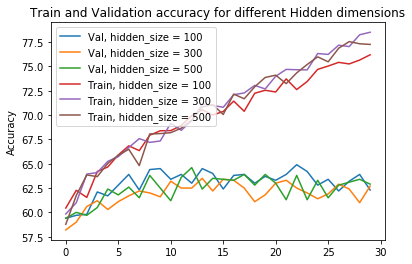

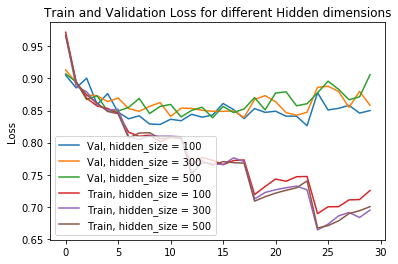

In [286]:
plt.clf()
for i, val_acc in enumerate(val_acc_total):
    plt.plot(val_acc, label='Val, hidden_size = %d' % hidden_sizes[i])
    
for i, trn_acc in enumerate(trn_acc_total):
    plt.plot(trn_acc, label='Train, hidden_size = %d' % hidden_sizes[i])
    
plt.title('Train and Validation accuracy for different Hidden dimensions')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(output_path+'cnn_hidden_size_acc.png')
plt.show()

plt.clf()
for i, val_loss in enumerate(val_loss_total):
    plt.plot(val_loss, label='Val, hidden_size = %d' % hidden_sizes[i])
    
for i, trn_loss in enumerate(trn_loss_total):
    plt.plot(trn_loss, label='Train, hidden_size = %d' % hidden_sizes[i])
    
plt.title('Train and Validation Loss for different Hidden dimensions')
plt.ylabel('Loss')
plt.legend()
plt.savefig(output_path+'cnn_hidden_size_loss.png')
plt.show()

In [287]:
# accandlosspath = './output_accandloss/cnn_hidden_size_'
# np.save(accandlosspath+'trn_acc_total', np.asarray(trn_acc_total))
# np.save(accandlosspath+'val_acc_total', np.asarray(val_acc_total))
# np.save(accandlosspath+'trn_loss_total', np.asarray(trn_loss_total))
# np.save(accandlosspath+'val_loss_total', np.asarray(val_loss_total))

## Kernal size of CNN

In [310]:
kernel_sizes = [1,2,3]

In [311]:
trn_acc_total = []
val_acc_total = []
trn_loss_total = []
val_loss_total = []

In [312]:
for kernel_size in kernel_sizes:
    trn_acc_values = []
    val_acc_values = []
    trn_loss_values = []
    val_loss_values = []
    
    model = CNN(in_size=300, hidden_size=100, num_classes=3, vocab=TEXT.vocab, kernel_size=kernel_size)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 8
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (batch) in enumerate(snli_train_iter):
            model.train()
            optimizer.zero_grad()
            pred = model(batch.sentence1, batch.sentence2)
            loss = F.cross_entropy(pred,batch.label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            val_period = 500
            if i > 0 and i % val_period == 0:
                # validate
                model.eval()
                trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
#                 trn_acc, trn_loss = -1, -1
                val_acc, val_loss = test_model(snli_val_iter, model)

                print('Epoch: [{}/{}], Step: [{}/{}], Trn Acc: {:.2f}, Val Acc: {:.2f}, Trn Loss: {:.2f}, Val Loss: {:.2f}'
                      .format(epoch+1, num_epochs, i+1, len(snli_train_iter), trn_acc, val_acc,
                              running_loss/val_period, val_loss))
                
                trn_acc_values.append(trn_acc)
                val_acc_values.append(val_acc)
                trn_loss_values.append(running_loss/val_period)
                val_loss_values.append(val_loss)
                
                running_loss = 0.0
                
    trn_acc_total.append(trn_acc_values)
    val_acc_total.append(val_acc_values)
    trn_loss_total.append(trn_loss_values)
    val_loss_total.append(val_loss_values)

Epoch: [1/8], Step: [501/3125], Trn Acc: 58.68, Val Acc: 58.70, Trn Loss: 0.98, Val Loss: 0.91
Epoch: [1/8], Step: [1001/3125], Trn Acc: 60.01, Val Acc: 60.60, Trn Loss: 0.90, Val Loss: 0.88
Epoch: [1/8], Step: [1501/3125], Trn Acc: 60.09, Val Acc: 58.70, Trn Loss: 0.88, Val Loss: 0.90
Epoch: [1/8], Step: [2001/3125], Trn Acc: 62.81, Val Acc: 62.10, Trn Loss: 0.87, Val Loss: 0.86
Epoch: [1/8], Step: [2501/3125], Trn Acc: 62.80, Val Acc: 62.00, Trn Loss: 0.86, Val Loss: 0.86
Epoch: [1/8], Step: [3001/3125], Trn Acc: 63.91, Val Acc: 62.70, Trn Loss: 0.85, Val Loss: 0.85
Epoch: [2/8], Step: [501/3125], Trn Acc: 64.45, Val Acc: 63.30, Trn Loss: 0.83, Val Loss: 0.84
Epoch: [2/8], Step: [1001/3125], Trn Acc: 64.92, Val Acc: 63.20, Trn Loss: 0.84, Val Loss: 0.84
Epoch: [2/8], Step: [1501/3125], Trn Acc: 65.32, Val Acc: 64.00, Trn Loss: 0.84, Val Loss: 0.84
Epoch: [2/8], Step: [2001/3125], Trn Acc: 65.81, Val Acc: 64.00, Trn Loss: 0.83, Val Loss: 0.83
Epoch: [2/8], Step: [2501/3125], Trn Acc: 

Epoch: [7/8], Step: [1501/3125], Trn Acc: 76.25, Val Acc: 64.50, Trn Loss: 0.68, Val Loss: 0.85
Epoch: [7/8], Step: [2001/3125], Trn Acc: 76.77, Val Acc: 64.60, Trn Loss: 0.68, Val Loss: 0.85
Epoch: [7/8], Step: [2501/3125], Trn Acc: 76.30, Val Acc: 63.90, Trn Loss: 0.69, Val Loss: 0.84
Epoch: [7/8], Step: [3001/3125], Trn Acc: 75.73, Val Acc: 63.50, Trn Loss: 0.69, Val Loss: 0.85
Epoch: [8/8], Step: [501/3125], Trn Acc: 77.70, Val Acc: 65.40, Trn Loss: 0.65, Val Loss: 0.84
Epoch: [8/8], Step: [1001/3125], Trn Acc: 77.46, Val Acc: 66.70, Trn Loss: 0.65, Val Loss: 0.84
Epoch: [8/8], Step: [1501/3125], Trn Acc: 78.09, Val Acc: 65.10, Trn Loss: 0.66, Val Loss: 0.84
Epoch: [8/8], Step: [2001/3125], Trn Acc: 78.55, Val Acc: 66.10, Trn Loss: 0.66, Val Loss: 0.83
Epoch: [8/8], Step: [2501/3125], Trn Acc: 78.50, Val Acc: 65.90, Trn Loss: 0.66, Val Loss: 0.84
Epoch: [8/8], Step: [3001/3125], Trn Acc: 78.61, Val Acc: 63.00, Trn Loss: 0.67, Val Loss: 0.86
Epoch: [1/8], Step: [501/3125], Trn Acc: 

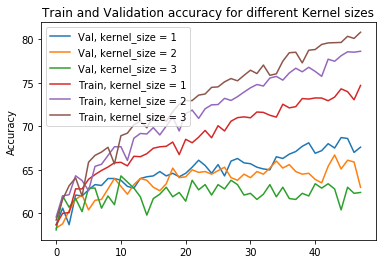

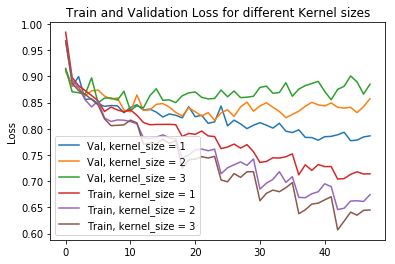

In [315]:
plt.clf()
for i, val_acc in enumerate(val_acc_total):
    plt.plot(val_acc, label='Val, kernel_size = %d' % kernel_sizes[i])
    
for i, trn_acc in enumerate(trn_acc_total):
    plt.plot(trn_acc, label='Train, kernel_size = %d' % kernel_sizes[i])
    
plt.title('Train and Validation accuracy for different Kernel sizes')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(output_path+'cnn_kernel_size_acc.png')
plt.show()

plt.clf()
for i, val_loss in enumerate(val_loss_total):
    plt.plot(val_loss, label='Val, kernel_size = %d' % kernel_sizes[i])
    
for i, trn_loss in enumerate(trn_loss_total):
    plt.plot(trn_loss, label='Train, kernel_size = %d' % kernel_sizes[i])
    
plt.title('Train and Validation Loss for different Kernel sizes')
plt.ylabel('Loss')
plt.legend()
plt.savefig(output_path+'cnn_kernel_size_loss.png')
plt.show()

In [316]:
# accandlosspath = './output_accandloss/cnn_kernel_size_'
# np.save(accandlosspath+'trn_acc_total', np.asarray(trn_acc_total))
# np.save(accandlosspath+'val_acc_total', np.asarray(val_acc_total))
# np.save(accandlosspath+'trn_loss_total', np.asarray(trn_loss_total))
# np.save(accandlosspath+'val_loss_total', np.asarray(val_loss_total))

## Dropout of CNN

In [318]:
dropouts = [0, 0.15, 0.4]

In [319]:
trn_acc_total = []
val_acc_total = []
trn_loss_total = []
val_loss_total = []

In [320]:
for dropout in dropouts:
    trn_acc_values = []
    val_acc_values = []
    trn_loss_values = []
    val_loss_values = []
    
    model = CNN(in_size=300, hidden_size=100, num_classes=3, vocab=TEXT.vocab, kernel_size=1, dropout=dropout)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 8
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (batch) in enumerate(snli_train_iter):
            model.train()
            optimizer.zero_grad()
            pred = model(batch.sentence1, batch.sentence2)
            loss = F.cross_entropy(pred,batch.label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            val_period = 500
            if i > 0 and i % val_period == 0:
                # validate
                model.eval()
                trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
                val_acc, val_loss = test_model(snli_val_iter, model)

                print('Epoch: [{}/{}], Step: [{}/{}], Trn Acc: {:.2f}, Val Acc: {:.2f}, Trn Loss: {:.2f}, Val Loss: {:.2f}'
                      .format(epoch+1, num_epochs, i+1, len(snli_train_iter), trn_acc, val_acc,
                              running_loss/val_period, val_loss))
                
                trn_acc_values.append(trn_acc)
                val_acc_values.append(val_acc)
                trn_loss_values.append(running_loss/val_period)
                val_loss_values.append(val_loss)
                
                running_loss = 0.0
                
    trn_acc_total.append(trn_acc_values)
    val_acc_total.append(val_acc_values)
    trn_loss_total.append(trn_loss_values)
    val_loss_total.append(val_loss_values)

Epoch: [1/8], Step: [501/3125], Trn Acc: 59.01, Val Acc: 57.70, Trn Loss: 0.98, Val Loss: 0.91
Epoch: [1/8], Step: [1001/3125], Trn Acc: 60.54, Val Acc: 58.60, Trn Loss: 0.90, Val Loss: 0.90
Epoch: [1/8], Step: [1501/3125], Trn Acc: 61.54, Val Acc: 61.00, Trn Loss: 0.87, Val Loss: 0.89
Epoch: [1/8], Step: [2001/3125], Trn Acc: 62.62, Val Acc: 61.30, Trn Loss: 0.88, Val Loss: 0.88
Epoch: [1/8], Step: [2501/3125], Trn Acc: 62.72, Val Acc: 62.10, Trn Loss: 0.86, Val Loss: 0.88
Epoch: [1/8], Step: [3001/3125], Trn Acc: 63.57, Val Acc: 62.30, Trn Loss: 0.86, Val Loss: 0.86
Epoch: [2/8], Step: [501/3125], Trn Acc: 64.71, Val Acc: 61.80, Trn Loss: 0.84, Val Loss: 0.85
Epoch: [2/8], Step: [1001/3125], Trn Acc: 65.18, Val Acc: 61.50, Trn Loss: 0.83, Val Loss: 0.86
Epoch: [2/8], Step: [1501/3125], Trn Acc: 65.55, Val Acc: 62.20, Trn Loss: 0.83, Val Loss: 0.85
Epoch: [2/8], Step: [2001/3125], Trn Acc: 65.73, Val Acc: 60.60, Trn Loss: 0.83, Val Loss: 0.86
Epoch: [2/8], Step: [2501/3125], Trn Acc: 

Epoch: [7/8], Step: [1501/3125], Trn Acc: 71.41, Val Acc: 65.80, Trn Loss: 0.74, Val Loss: 0.81
Epoch: [7/8], Step: [2001/3125], Trn Acc: 70.65, Val Acc: 64.80, Trn Loss: 0.75, Val Loss: 0.82
Epoch: [7/8], Step: [2501/3125], Trn Acc: 71.54, Val Acc: 65.80, Trn Loss: 0.75, Val Loss: 0.81
Epoch: [7/8], Step: [3001/3125], Trn Acc: 72.50, Val Acc: 65.60, Trn Loss: 0.74, Val Loss: 0.81
Epoch: [8/8], Step: [501/3125], Trn Acc: 72.40, Val Acc: 67.00, Trn Loss: 0.71, Val Loss: 0.81
Epoch: [8/8], Step: [1001/3125], Trn Acc: 72.58, Val Acc: 66.30, Trn Loss: 0.73, Val Loss: 0.81
Epoch: [8/8], Step: [1501/3125], Trn Acc: 73.08, Val Acc: 66.40, Trn Loss: 0.74, Val Loss: 0.79
Epoch: [8/8], Step: [2001/3125], Trn Acc: 72.99, Val Acc: 67.10, Trn Loss: 0.72, Val Loss: 0.80
Epoch: [8/8], Step: [2501/3125], Trn Acc: 72.83, Val Acc: 65.40, Trn Loss: 0.74, Val Loss: 0.80
Epoch: [8/8], Step: [3001/3125], Trn Acc: 73.40, Val Acc: 66.30, Trn Loss: 0.74, Val Loss: 0.81
Epoch: [1/8], Step: [501/3125], Trn Acc: 

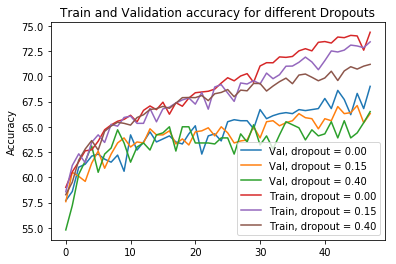

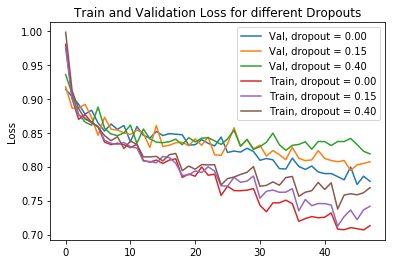

In [322]:
plt.clf()
for i, val_acc in enumerate(val_acc_total):
    plt.plot(val_acc, label='Val, dropout = %.2f' % dropouts[i])
    
for i, trn_acc in enumerate(trn_acc_total):
    plt.plot(trn_acc, label='Train, dropout = %.2f' % dropouts[i])
    
plt.title('Train and Validation accuracy for different Dropouts')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(output_path+'cnn_dropout_acc.png')
plt.show()

plt.clf()
for i, val_loss in enumerate(val_loss_total):
    plt.plot(val_loss, label='Val, dropout = %.2f' % dropouts[i])
    
for i, trn_loss in enumerate(trn_loss_total):
    plt.plot(trn_loss, label='Train, dropout = %.2f' % dropouts[i])
    
plt.title('Train and Validation Loss for different Dropouts')
plt.ylabel('Loss')
plt.legend()
plt.savefig(output_path+'cnn_dropout_loss.png')
plt.show()

In [323]:
# accandlosspath = './output_accandloss/cnn_dropout_'
# np.save(accandlosspath+'trn_acc_total', np.asarray(trn_acc_total))
# np.save(accandlosspath+'val_acc_total', np.asarray(val_acc_total))
# np.save(accandlosspath+'trn_loss_total', np.asarray(trn_loss_total))
# np.save(accandlosspath+'val_loss_total', np.asarray(val_loss_total))

In [396]:
def get_example(iterator):
    rightPred = []
    wrongPred = []
    rightIdx = []
    wrongIdx = []
    model.eval()
    for batch in iterator:
        sentence1,sentence2,label = batch.sentence1,batch.sentence2, batch.label
        batch_size = iterator.batch_size
        
        pred = model(sentence1, sentence2)
        outputs = F.softmax(pred, dim=1)
        pred = outputs.max(1, keepdim=True)[1]
        pred = pred.cpu().numpy().reshape(batch_size)
        corr = label.cpu().numpy()
        
        for j in range(batch_size):
            if pred[j] == corr[j]:
                rightPred.append(pred[j])
                rightIdx.append(j)
            else:
                wrongPred.append(pred[j])
                wrongIdx.append(j)
                
        for i in range(len(rightIdx)):
            print("Sentence1: %s" % (TEXT.reverse(sentence1[0].data)[rightIdx[i]]))
            print("Sentence2: %s" % (TEXT.reverse(sentence2[0].data)[rightIdx[i]]))
            print("P: %d" % (rightPred[i]))
            print("C: %d" % (corr[rightIdx[i]]))
            if i > 7:
                break
        for i in range(len(wrongIdx)):
            print("Sentence1: %s" % (TEXT.reverse(sentence1[0].data)[wrongIdx[i]]))
            print("Sentence2: %s" % (TEXT.reverse(sentence2[0].data)[wrongIdx[i]]))
            print("P: %d" % (wrongPred[i]))
            print("C: %d" % (corr[wrongIdx[i]]))
            if i > 7:
                break
        break

In [397]:
get_example(snli_val_iter)

Sentence1: four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
Sentence2: multiple people are on a subway together , with each of them doing their own thing .
P: 1
C: 1
Sentence1: bicycles stationed while a group of people socialize .
Sentence2: people get together near a stand of bicycles .
P: 1
C: 1
Sentence1: man in overalls with two horses .
Sentence2: a man in overalls with two horses
P: 1
C: 1
Sentence1: man observes a wavelength given off by an electronic device .
Sentence2: the man is examining what wavelength is given off by the device .
P: 1
C: 1
Sentence1: two men are listening to music through headphones .
Sentence2: two men listen to music .
P: 1
C: 1
Sentence1: a group of numbered participants walk down the street together .
Sentence2: participants wait for the beginning of the walkathon .
P: 2
C: 2
Sentence1: a man wearing glasses is vacuuming an architects model .
Sentence2: there is a man vaucuming
P: 1
C: 1
Sentence1:

## ----------------------------------------------------------------------------------------------------------

# Evaluating on MultiNLI

In [425]:
TEXT = torchtext.data.ReversibleField(sequential=True, lower=True, include_lengths=True,
                                      batch_first=True)
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, preprocessing=lambda x: label_map[x])
GENRE = torchtext.data.ReversibleField(sequential=False, use_vocab=True)

In [426]:
snli_train_data = torchtext.data.TabularDataset(snli_train_path,format='tsv', 
                                                    skip_header = True,
                                                    fields=[('sentence1',TEXT),('sentence2',TEXT),('label',LABEL)])
snli_val_data = torchtext.data.TabularDataset(snli_val_path,format='tsv', 
                                                  skip_header = True,
                                                  fields=[('sentence1',TEXT),('sentence2',TEXT),('label',LABEL)])
mnli_val_data = torchtext.data.TabularDataset(mnli_val_path,format='tsv', skip_header = True,
                                                   fields=[('sentence1',TEXT),('sentence2',TEXT),
                                                           ('label',LABEL),('genre',GENRE)])

In [427]:
TEXT.build_vocab(snli_train_data, snli_val_data, mnli_val_data,
                 vectors=torchtext.vocab.Vectors(name='wiki-news-300d-1M.vec'))
GENRE.build_vocab(mnli_val_data)

In [428]:
snli_train_iter = torchtext.data.BucketIterator(snli_train_data,
                                                batch_size=32,
                                                shuffle=True,
#                                                 sort_key=lambda x: len(x.sentence1)+len(x.sentence2),
                                                sort_key=lambda x: data.interleave_keys(len(x.sentence1), len(x.sentence2)),
                                                device=torch.device('cuda'))
snli_val_iter = torchtext.data.BucketIterator(snli_val_data,
                                                batch_size=32,
                                                shuffle=False,
#                                                 sort_key=lambda x: len(x.sentence1)+len(x.sentence2),
                                                sort_key=lambda x: data.interleave_keys(len(x.sentence1), len(x.sentence2)),
                                                device=torch.device('cuda'))
# mnli_val_iter = torchtext.data.BucketIterator(mnli_val_data,
#                                                 batch_size=32,
#                                                 shuffle=False,
# #                                                 sort_key=lambda x: len(x.sentence1)+len(x.sentence2),
#                                                 sort_key=lambda x: data.interleave_keys(len(x.sentence1), len(x.sentence2)),
#                                                 device=torch.device('cuda'))

In [471]:
GENRE.vocab.itos

[' UNK ', 'government', 'telephone', 'slate', 'fiction', 'travel']

In [430]:
mnli_val_data_genres = []
genre_stoi = GENRE.vocab.stoi
for i in range(len(genre_stoi)-1):
    mnli_val_data_genres.append([])
for mnli_data in mnli_val_data:
    mnli_val_data_genres[genre_stoi[(mnli_data.genre)]-1].append(mnli_data)

In [441]:
len(mnli_val_data_genres[1])

1005

In [443]:
mnli_val_iter_genres = []

In [444]:
for i, (mnli_data_genres) in enumerate(mnli_val_data_genres):
    mnli_val_data_genres[i] = torchtext.data.Dataset(mnli_data_genres, fields=[('sentence1',TEXT),('sentence2',TEXT),
                                                           ('label',LABEL),('genre',GENRE)])
    mnli_val_iter_genres.append(torchtext.data.BucketIterator(mnli_val_data_genres[i],
                                                batch_size=32,
                                                shuffle=False,
#                                                 sort_key=lambda x: len(x.sentence1)+len(x.sentence2),
                                                sort_key=lambda x: data.interleave_keys(len(x.sentence1), len(x.sentence2)),
                                                device=torch.device('cuda')))

In [446]:
print(mnli_val_iter_genres[1])

## Train RNN

In [447]:
model_rnn = RNN(in_size=300, hidden_size=100, num_classes=3, vocab=TEXT.vocab, num_layers=1, dropout=0)
model_rnn.cuda()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

num_epochs = 8
for epoch in range(num_epochs):
#     running_loss = 0.0
    for i, (batch) in enumerate(snli_train_iter):
        model_rnn.train()
        optimizer.zero_grad()
        pred = model_rnn(batch.sentence1, batch.sentence2)
        loss = F.cross_entropy(pred,batch.label)
        loss.backward()
        optimizer.step()
#         running_loss += loss.item()

        val_period = 3000
        if i > 0 and i % val_period == 0:
            # validate
            model_rnn.eval()
#             trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
            val_acc, val_loss = test_model(snli_val_iter, model_rnn)

            print('Epoch: [{}/{}], Step: [{}/{}], Val Acc: {:.2f}'
                  .format(epoch+1, num_epochs, i+1, len(snli_train_iter), val_acc))

Epoch: [1/8], Step: [3001/3125], Val Acc: 60.40
Epoch: [2/8], Step: [3001/3125], Val Acc: 62.10
Epoch: [3/8], Step: [3001/3125], Val Acc: 63.70
Epoch: [4/8], Step: [3001/3125], Val Acc: 66.80
Epoch: [5/8], Step: [3001/3125], Val Acc: 67.40
Epoch: [6/8], Step: [3001/3125], Val Acc: 68.20
Epoch: [7/8], Step: [3001/3125], Val Acc: 67.50
Epoch: [8/8], Step: [3001/3125], Val Acc: 68.40


In [ ]:
# torch.save(model_rnn, './models/rnn')

In [457]:
rnn_output = []
for mnli_iter_genre in mnli_val_iter_genres:
    rnn_output.append(test_model(mnli_iter_genre, model_rnn)[0])

In [469]:
rnn_output

[43.503937007874015,
 44.27860696517413,
 41.71656686626746,
 44.824120603015075,
 45.31568228105906]

## Train CNN

In [472]:
model_cnn = CNN(in_size=300, hidden_size=100, num_classes=3, vocab=TEXT.vocab, kernel_size=1, dropout=0.0)
model_cnn.cuda()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

num_epochs = 8
for epoch in range(num_epochs):
#     running_loss = 0.0
    for i, (batch) in enumerate(snli_train_iter):
        model_cnn.train()
        optimizer.zero_grad()
        pred = model_cnn(batch.sentence1, batch.sentence2)
        loss = F.cross_entropy(pred,batch.label)
        loss.backward()
        optimizer.step()
#         running_loss += loss.item()

        val_period = 3000
        if i > 0 and i % val_period == 0:
            # validate
            model_cnn.eval()
#             trn_acc, trn_loss = test_model(snli_train_iter_for_val, model)
            val_acc, val_loss = test_model(snli_val_iter, model_cnn)

            print('Epoch: [{}/{}], Step: [{}/{}], Val Acc: {:.2f}'
                  .format(epoch+1, num_epochs, i+1, len(snli_train_iter), val_acc))

Epoch: [1/8], Step: [3001/3125], Val Acc: 62.50
Epoch: [2/8], Step: [3001/3125], Val Acc: 63.80
Epoch: [3/8], Step: [3001/3125], Val Acc: 64.20
Epoch: [4/8], Step: [3001/3125], Val Acc: 65.00
Epoch: [5/8], Step: [3001/3125], Val Acc: 65.00
Epoch: [6/8], Step: [3001/3125], Val Acc: 66.50
Epoch: [7/8], Step: [3001/3125], Val Acc: 66.50
Epoch: [8/8], Step: [3001/3125], Val Acc: 69.30


In [ ]:
# torch.save(model_cnn, './models/cnn')

In [467]:
cnn_output = []
for mnli_iter_genre in mnli_val_iter_genres:
    cnn_output.append(test_model(mnli_iter_genre, model_cnn)[0])

In [468]:
cnn_output

[45.57086614173228,
 46.666666666666664,
 42.71457085828343,
 43.41708542713568,
 44.29735234215886]

## ----------------------------------------------------------------------------------------------------------

In [ ]:
for batch in snli_train_iter:
    print(batch.sentence1[0].shape)
    break

In [ ]:
m = nn.MaxPool1d(3, stride=3)
input = torch.randn(2,3,4)
print(input)
print(torch.max(input, dim=1)[0])
print(m(input).shape)

In [ ]:
x = torch.rand(5, 3, 224, 224)
x.view(x.size(0), -1).shape

In [ ]:
a = np.random.randint(20, size=10)
print(a)
b = np.argsort(-a)
print(b)
print(a[b])
c = np.argsort(b)
print(c)
print(a[b][c])

In [ ]:
a = torch.rand(2,3,4)
b = torch.cat([a,a],dim=0)
print(a.shape)
print(b.shape)
print(b)